In [17]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

## Read Train data

In [18]:

train_home_team_statistics_df = pd.read_csv('./data/Train_data/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('./data/Train_data/train_away_team_statistics_df.csv', index_col=0)

train_scores = pd.read_csv("./data/Y_train.csv", index_col=0)

train_home = train_home_team_statistics_df.iloc[:,2:]
train_away = train_away_team_statistics_df.iloc[:,2:]

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data =  pd.concat([train_home,train_away],join='inner',axis=1)
train_scores = train_scores.loc[train_data.index]

train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan})


In [19]:
train_home_team_statistics_df.head()

,LEAGUE,TEAM_NAME,TEAM_SHOTS_TOTAL_season_sum,TEAM_SHOTS_INSIDEBOX_season_sum,TEAM_SHOTS_OFF_TARGET_season_sum,TEAM_SHOTS_ON_TARGET_season_sum,TEAM_SHOTS_OUTSIDEBOX_season_sum,TEAM_PASSES_season_sum,TEAM_SUCCESSFUL_PASSES_season_sum,TEAM_SAVES_season_sum,...,TEAM_YELLOWCARDS_5_last_match_std,TEAM_REDCARDS_5_last_match_std,TEAM_OFFSIDES_5_last_match_std,TEAM_ATTACKS_5_last_match_std,TEAM_PENALTIES_5_last_match_std,TEAM_SUBSTITUTIONS_5_last_match_std,TEAM_BALL_SAFE_5_last_match_std,TEAM_DANGEROUS_ATTACKS_5_last_match_std,TEAM_INJURIES_5_last_match_std,TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
0,Ligue 1,Toulouse,3.0,2.0,5.0,2.0,1.0,2.0,2.0,5.0,...,3.0,0.0,6.0,0.0,10.0,8.0,7.0,2.0,4.0,3.0
1,Ligue 2,Brest,6.0,8.0,3.0,6.0,5.0,8.0,7.0,10.0,...,4.0,0.0,4.0,3.0,10.0,0.0,1.0,2.0,8.0,4.0
2,Serie A,Sampdoria,4.0,2.0,5.0,2.0,8.0,1.0,1.0,2.0,...,4.0,5.0,6.0,3.0,6.0,7.0,2.0,3.0,2.0,4.0
3,League One,Coventry City,7.0,5.0,5.0,6.0,6.0,9.0,9.0,2.0,...,4.0,0.0,1.0,8.0,8.0,5.0,5.0,5.0,NaN,6.0
4,Premier League,Wolverhampton Wanderers,3.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,...,1.0,0.0,2.0,5.0,8.0,7.0,2.0,6.0,4.0,4.0


In [20]:
train_scores.head()

,HOME_WINS,DRAW,AWAY_WINS
ID,,,
0,0,0,1
1,0,1,0
2,0,0,1
3,1,0,0
4,0,1,0


## Benchmark

We try to model if AWAY wins

In [21]:
train_new_y_h_wins = train_scores['HOME_WINS']
train_new_y_a_wins = train_scores['AWAY_WINS']
train_new_y_draw = train_scores['DRAW']


### train, valid test split

In [22]:
X_train_away, X_test_away, y_train_away, y_test_away = model_selection.train_test_split(train_data, train_new_y_a_wins, train_size=0.8, random_state=42)
X_train_away, X_valid_away, y_train_away, y_valid_away = model_selection.train_test_split(X_train_away, y_train_away, train_size=0.8, random_state=42)

X_train_home, X_test_home, y_train_home, y_test_home = model_selection.train_test_split(train_data, train_new_y_h_wins, train_size=0.8, random_state=42)
X_train_home, X_valid_home, y_train_home, y_valid_home = model_selection.train_test_split(X_train_home, y_train_home, train_size=0.8, random_state=42)

X_train_draw, X_test_draw, y_train_draw, y_test_draw = model_selection.train_test_split(train_data, train_new_y_draw, train_size=0.8, random_state=42)
X_train_draw, X_valid_draw, y_train_draw, y_valid_draw = model_selection.train_test_split(X_train_draw, y_train_draw, train_size=0.8, random_state=42)



### xgb model

In [23]:
params_1 = {
    'booster': 'gbtree',
    'tree_method':'hist',
    'max_depth': 12, 
    'learning_rate': 0.1,
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric':'mlogloss',
    }


d_train_away = xgb.DMatrix(X_train_away, label=y_train_away)
d_valid_away = xgb.DMatrix(X_valid_away, label=y_valid_away)

num_round = 50_000_000

evallist_away = [(d_train_away, 'train'), (d_valid_away, 'valid')]

bst_away = xgb.train(params_1, d_train_away, num_round, evallist_away, early_stopping_rounds=100, verbose_eval=1000)



[0]	train-mlogloss:0.99416	valid-mlogloss:1.04143
[143]	train-mlogloss:0.00986	valid-mlogloss:0.68734


### Some analysis

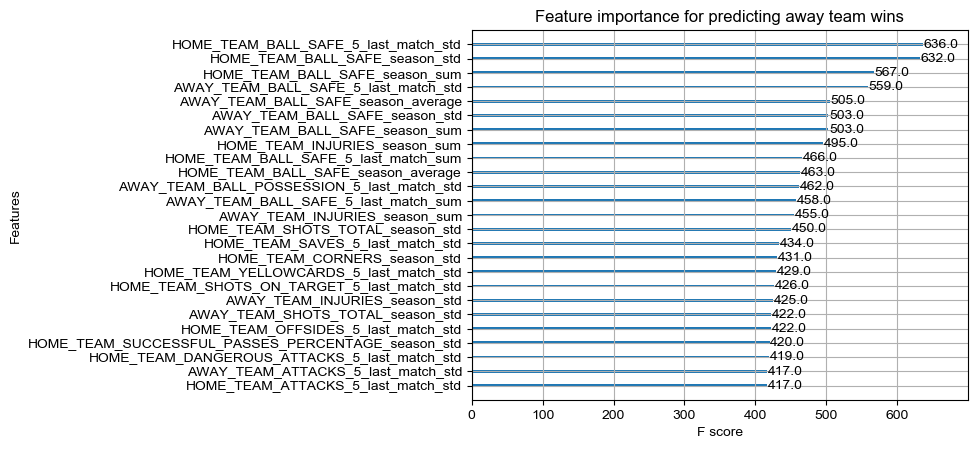

In [24]:
plt.rcParams['font.family'] = 'Arial'
xgb.plot_importance(bst_away, max_num_features=25, title='Feature importance for predicting away team wins')

### Accuracy on test set

A simple benchmark is always predicting home wins

In [25]:
target = train_scores.loc[X_test_away.index].copy()

home_wins = target
home_wins = 0 * home_wins
home_wins.iloc[:,0] = 1

np.round(accuracy_score(home_wins,target),4)

0.4401

Using our model

In [26]:
X_test_xgb_away = xgb.DMatrix(X_test_away)


predictions_away = bst_away.predict(X_test_xgb_away, iteration_range=(0, bst_away.best_iteration))

predictions_away = pd.DataFrame(predictions_away)

predictions_away[2] = 0

predictions_away.columns = [0,2,1]

predictions_away = (predictions_away.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int).values

print("prediction for away wins", np.round(accuracy_score(predictions_away, target),4))


prediction for away wins 0.475


## Submission

In [27]:
test_home = pd.read_csv('./data/Test_data/test_home_team_statistics_df.csv', index_col=0)
test_away = pd.read_csv('./data/Test_data/test_away_team_statistics_df.csv', index_col=0)

test_home.columns = 'HOME_' + test_home.columns
test_away.columns = 'AWAY_' + test_away.columns

test_data =  pd.concat([test_home,test_away],join='inner',axis=1)


In [28]:
X_bench = xgb.DMatrix(test_data)

predictions = bst_away.predict(X_bench, iteration_range=(0, bst_away.best_iteration))
predictions = pd.DataFrame(predictions)
predictions.head()

predictions[2] = 0
predictions.columns = [0,2,1]
predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int)

predictions.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']
predictions.index = test_data.index
submission = predictions.reset_index()


In [29]:

xgb.cv(
    params=params_1,
    dtrain=d_train_away,
    num_boost_round=500,
    nfold=5,
    metrics='mlogloss',
    early_stopping_rounds=10,
    seed=42
)

,train-mlogloss-mean,train-mlogloss-std,test-mlogloss-mean,test-mlogloss-std
0,0.993016,0.000753,1.042718,0.001666
1,0.901369,0.001270,0.996448,0.003298
2,0.821615,0.001597,0.956271,0.004624
3,0.750539,0.002123,0.921509,0.004467
4,0.687271,0.002112,0.891538,0.005413
5,0.630715,0.002781,0.864933,0.006601
6,0.580014,0.002581,0.840565,0.006368
7,0.535324,0.002912,0.820481,0.007179
8,0.494482,0.002885,0.802237,0.007264
9,0.456696,0.002870,0.786061,0.008107


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005404 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.560761


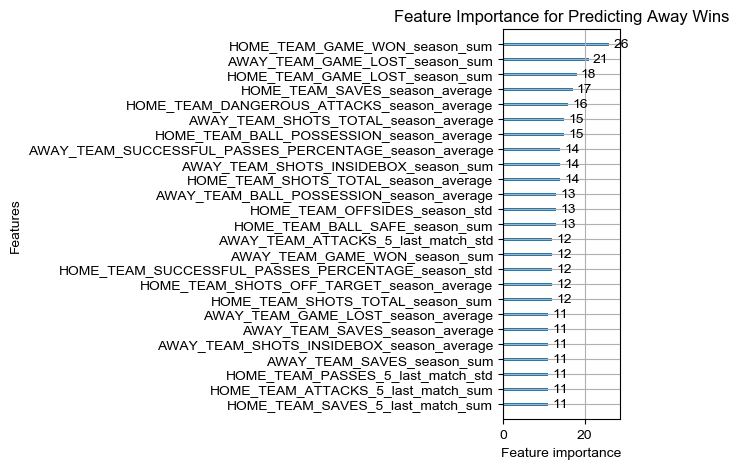

Probabilités de classe pour chaque échantillon :
[[0.79679435 0.20320565]
 [0.72411386 0.27588614]
 [0.60338072 0.39661928]
 ...
 [0.54647248 0.45352752]
 [0.7613041  0.2386959 ]
 [0.61667657 0.38332343]]
Shape of predictions: (2461, 2)
Prediction for away wins: 0.707


In [30]:
import lightgbm as lgb


params_2 = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 2,
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

d_train_away = lgb.Dataset(X_train_away, label=y_train_away)
d_valid_away = lgb.Dataset(X_valid_away, label=y_valid_away)


num_round = 50_000_000
evallist_away = [(d_train_away, 'train'), (d_valid_away, 'valid')]
bst_away = lgb.train(params_2, d_train_away, num_round, valid_sets=d_valid_away, early_stopping_rounds=100, verbose_eval=1000)

plt.rcParams['font.family'] = 'Arial'
lgb.plot_importance(bst_away, max_num_features=25, title='Feature Importance for Predicting Away Wins')
plt.tight_layout()
plt.show()


predictions_away = bst_away.predict(X_test_away, num_iteration=bst_away.best_iteration)

print("Probabilités de classe pour chaque échantillon :")
print(predictions_away)


print("Shape of predictions:", predictions_away.shape)

predictions_away = np.argmax(predictions_away, axis=1)


predictions_away_df = pd.DataFrame(predictions_away, columns=['Prediction'])


print("Prediction for away wins:", np.round(accuracy_score(y_test_away, predictions_away), 4))

# predictions_away_df.head(60)



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005848 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.64118


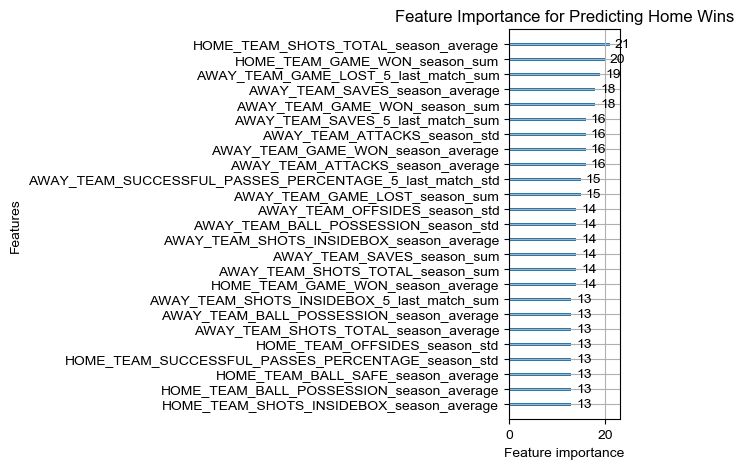

Probabilités de classe pour chaque échantillon :
[[0.41287579 0.58712421]
 [0.61011181 0.38988819]
 [0.6777144  0.3222856 ]
 ...
 [0.65077252 0.34922748]
 [0.55141808 0.44858192]
 [0.74412773 0.25587227]]
Shape of predictions: (2461, 2)
Prediction for home wins: 0.6209


In [31]:
# test avec comme cible les victoires à domicile

params_3 = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 2,
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

d_train_home = lgb.Dataset(X_train_home, label=y_train_home)
d_valid_home = lgb.Dataset(X_valid_home, label=y_valid_home)

num_round = 50_000_000
evallist_home = [(d_train_home, 'train'), (d_valid_home, 'valid')]

bst_home = lgb.train(params_3, d_train_home, num_round, valid_sets=d_valid_home, early_stopping_rounds=100, verbose_eval=1000)

plt.rcParams['font.family'] = 'Arial'
lgb.plot_importance(bst_home, max_num_features=25, title='Feature Importance for Predicting Home Wins')
plt.tight_layout()

plt.show()

predictions_home = bst_home.predict(X_test_home, num_iteration=bst_home.best_iteration)

print("Probabilités de classe pour chaque échantillon :")
print(predictions_home)

print("Shape of predictions:", predictions_home.shape)
predictions_home = np.argmax(predictions_home, axis=1)

predictions_home_df = pd.DataFrame(predictions_home, columns=['Prediction'])

print("Prediction for home wins:", np.round(accuracy_score(y_test_home, predictions_home), 4))




[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005279 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15]	valid_0's multi_logloss: 0.570847
Probabilités de classe pour chaque échantillon :
[[0.75147967 0.24852033]
 [0.6680195  0.3319805 ]
 [0.74933006 0.25066994]
 ...
 [0.59897416 0.40102584]
 [0.76605473 0.23394527]
 [0.67820283 0.32179717]]
Shape of predictions: (2461, 2)
Prediction for draws: 0.7481
          0         1
0  0.668992  0.331008
1  0.581632  0.418368
2  0.850169  0.149831
3  0.757221  0.242779
4  0.596061  0.403939
          0         1
0  0.586708  0.413292
1  0.780900  0.219100
2  0.305676  0.694324
3  0.603143  0.396857
4  0.684125  0.315875
          0         1
0  0.698593  0.301407
1  0.711753  0.288247
2  0.750568  0.249432
3  0.718555  0.281445
4  0.698763  0.301237


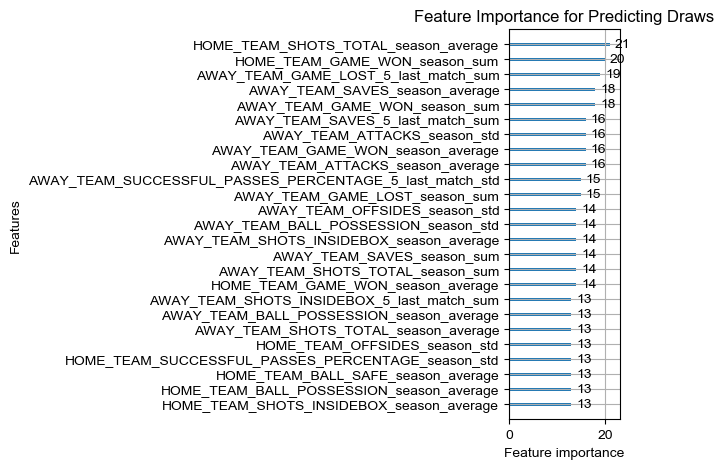

In [32]:
# test avec comme cible les matchs nuls

params_4 = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 2,
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

d_train_draw = lgb.Dataset(X_train_draw, label=y_train_draw)
d_valid_draw = lgb.Dataset(X_valid_draw, label=y_valid_draw)

num_round = 50_000_000
evallist_draw = [(d_train_draw, 'train'), (d_valid_draw, 'valid')]

bst_draw = lgb.train(params_4, d_train_draw, num_round, valid_sets=d_valid_draw, early_stopping_rounds=100, verbose_eval=1000)

predictions_draw = bst_draw.predict(X_test_draw, num_iteration=bst_draw.best_iteration)

print("Probabilités de classe pour chaque échantillon :")
print(predictions_draw)

print("Shape of predictions:", predictions_draw.shape)
predictions_draw = np.argmax(predictions_draw, axis=1)

predictions_draw_df = pd.DataFrame(predictions_draw, columns=['Prediction'])
lgb.plot_importance(bst_home, max_num_features=25, title='Feature Importance for Predicting Draws')
plt.tight_layout()

print("Prediction for draws:", np.round(accuracy_score(y_test_draw, predictions_draw), 4))


# Génerer une dataframe avec les bons id
test_home = pd.read_csv('./data/Test_Data/test_home_team_statistics_df.csv', index_col=0)
test_away = pd.read_csv('./data/Test_Data/test_away_team_statistics_df.csv', index_col=0)

test_home.columns = 'HOME_' + test_home.columns
test_away.columns = 'AWAY_' + test_away.columns

test_data =  pd.concat([test_home,test_away],join='inner',axis=1)

X_bench = test_data

predictions_away = bst_away.predict(X_bench, num_iteration=bst_away.best_iteration)
predictions_home = bst_home.predict(X_bench, num_iteration=bst_home.best_iteration)
predictions_draw = bst_draw.predict(X_bench, num_iteration=bst_draw.best_iteration)

predictions_away = pd.DataFrame(predictions_away)
predictions_home = pd.DataFrame(predictions_home)
predictions_draw = pd.DataFrame(predictions_draw)

print(predictions_away.head())
print(predictions_home.head())
print(predictions_draw.head())

# Concatene les 2 eme colonnes de chaque dataframe
predictions = pd.concat([predictions_home[1], predictions_draw[1], predictions_away[1]], axis=1)
predictions.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']
predictions.index = test_data.index
# put the max value to 1 and the others to 0
predictions = (predictions.reindex(columns=['HOME_WINS', 'DRAW', 'AWAY_WINS']).rank(1,ascending=False)==1).astype(int)
submission = predictions.reset_index()

submission.to_csv('./submission.csv', index=False)


